<a href="https://colab.research.google.com/github/neworderby/Python_EDA_ML/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BE%D0%BD%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D0%B8_%D0%B2_%D0%BE%D0%BF%D0%BB%D0%B0%D1%82%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Содержание

1. Описание задания
2. Импорт библиотек для работы
3. Загрузка данных
4. Предварительная очистка и преобразование данных
5. Промежуточный анализ датасета
6. Построение модели прогнозирования конверсии

## 1. Описание задачи

### Необходимо спрогнозировать конверсию на следующий год

- Спрогнозировать конверсии в первую оплату для следующего года. Прогноз нужно сделать на каждый день отдельно для каждого канала.
- Вывести данные о недельной и годовой сезонности, которые дает модель и сравнить их со средней конверсией в каждый день недели и каждый месяц.
- Оценить ошибку модели. Визуализировать предсказания и компоненты временного ряда.
- *В качестве дополнительного задания построй общий помесячный средневзвешенный прогноз для обоих каналов. Это позволит корректно спланировать финансовые показатели на уровне всей компании.*

### Данные

Файл с выгрузкой данных о посещениях сайта и покупках с указанием даты и времени посещения и покупки, а также — с указанием канала, из которого пришел потенциальный клиент.

### Каналы привлечения

1. органический трафик из поисковых систем
2. публикации блогеров
3. В прошлом году в качестве эксперимента проводили большую рекламную кампанию в конце года, привлекая трафик из нового для себя канала — баннеров на специализированных площадках с обзорами игр. Результаты оказались не очень, так что в следующем году решили не использовать этот канал.

### Дополнительные условия

- Конверсионное окно — 7 дней с даты посещения. Если покупка совершена позже, не следует ее учитывать как успешную конверсию.
- Есть данные о «посещениях» в будущем, в 2021 году. Это — синтетические данные, которые позволят посчитать, сколько посещений сайта ожидается в следующем году в каждый день / месяц в каждом канале. Использовать их в обучении моделей или тестировании результатов не нужно.

## 2. Импорт библиотек для работы

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fbprophet import Prophet
from datetime import date, datetime, timedelta
warnings.filterwarnings('ignore') #предварительно отключаем предупреждения

## 3. Загрузка данных

In [ ]:
# df_all = pd.read_csv('marketing_dataset.csv')

https://drive.google.com/file/d/1gcsrveRDn5t_ume15aEXsf10OQeLEB7_/view?usp=sharing

In [ ]:
! gdown --id 1gcsrveRDn5t_ume15aEXsf10OQeLEB7_

Downloading...
From: https://drive.google.com/uc?id=1gcsrveRDn5t_ume15aEXsf10OQeLEB7_
To: /content/marketing_dataset.csv
100% 38.7M/38.7M [00:00<00:00, 93.1MB/s]


In [ ]:
df_all = pd.read_csv('/content/marketing_dataset.csv')

Пришлось рисовать график конверсии в 2021 по каналам на работе, поэтому подключился через google colab. Для удобства оставил предыдущий способ подключения.

## 4. Предварительная очистка и преобразование данных

In [ ]:
df_all

,Unnamed: 0,visit_date,conversion_date,channel
0,0,2015-01-01 15:16:08.239468,NaN,bloggers
1,1,2015-01-01 14:24:41.728927,NaN,bloggers
2,2,2015-01-01 12:03:01.710107,NaN,bloggers
3,3,2015-01-01 15:03:26.306819,NaN,bloggers
4,4,2015-01-01 13:00:58.124915,NaN,bloggers
...,...,...,...,...
869726,85,2019-11-30 12:35:22.752916,NaN,direct
869727,86,2019-11-30 11:48:22.611818,2019-12-05 23:24:51.463522,direct
869728,87,2019-11-30 11:16:06.211602,NaN,direct
869729,88,2019-11-30 11:30:02.416155,NaN,direct


Переименовывываем столбцы

In [ ]:
df_all.columns = ['un_col','visit_date','conversion_date','channel']

In [ ]:
df_all.head(1)

,un_col,visit_date,conversion_date,channel
0,0,2015-01-01 15:16:08.239468,NaN,bloggers


In [ ]:
df = df_all.drop('un_col',axis=1)

После краткого ознакомления с датасетом, мне стало понятно, что в этой колонке скрывается количество посетителей за день. Поэтому для дальнейшей работы решил его убрать.

### Смотрим общую информацию о датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869731 entries, 0 to 869730
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   visit_date       869731 non-null  object
 1   conversion_date  103514 non-null  object
 2   channel          869731 non-null  object
dtypes: object(3)
memory usage: 19.9+ MB


Видим, что количество строк 869731. Пропусков нет. Необходимо будет преобразовать тип данных в столбцах с временем визита и конверсии в формат дата-время.

In [ ]:
df.describe()

,visit_date,conversion_date,channel
count,869731,103514,869731
unique,869731,103514,3
top,2018-12-31 11:29:29.377443,2016-06-10 12:51:36.759045,organics
freq,1,1,522767


Предварительно: количество записей в столбце с датой конверсии составляет 103514.
Наиболее часто встречающийся вид трафика в таблице - органический.

In [ ]:
df.isna().mean()

visit_date         0.000000
conversion_date    0.880982
channel            0.000000
dtype: float64

Доля пустых значений в столбце с датой конверсии - 88%.
Соответственно доля непустых значений (данных о конверсии) составляет 12%.

#### В условии задания сказано, что необходим прогноз на день. Наш датасет имеет другую гранулярность. Для начала необходимо преобразовать дату в нужный формат.

Для начала преобразуем столбцы сразу в date с помощью .dt.normalize():

In [ ]:
df['visit_date'] = pd.to_datetime(df['visit_date']).dt.normalize()
df['conversion_date'] = pd.to_datetime(df['conversion_date']).dt.normalize()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869731 entries, 0 to 869730
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   visit_date       869731 non-null  datetime64[ns]
 1   conversion_date  103514 non-null  datetime64[ns]
 2   channel          869731 non-null  object        
dtypes: datetime64[ns](2), object(1)
memory usage: 19.9+ MB


Функция dt.date отображает информацию в формате даты, но преобразует тип данных в текстовый.
dt.normalize() был выбран также по той причине, что нам необходимо вычислять окно конверсии (timedelta).

In [ ]:
df

,visit_date,conversion_date,channel
0,2015-01-01,NaT,bloggers
1,2015-01-01,NaT,bloggers
2,2015-01-01,NaT,bloggers
3,2015-01-01,NaT,bloggers
4,2015-01-01,NaT,bloggers
...,...,...,...
869726,2019-11-30,NaT,direct
869727,2019-11-30,2019-12-05,direct
869728,2019-11-30,NaT,direct
869729,2019-11-30,NaT,direct


Добавляем в датасет информацию об окне конверсии:

In [ ]:
df['window'] = (df['conversion_date'] - df['visit_date']).dt.days

In [ ]:
df.tail()

,visit_date,conversion_date,channel,window
869726,2019-11-30,NaT,direct,NaN
869727,2019-11-30,2019-12-05,direct,5.0
869728,2019-11-30,NaT,direct,NaN
869729,2019-11-30,NaT,direct,NaN
869730,2019-11-30,NaT,direct,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869731 entries, 0 to 869730
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   visit_date       869731 non-null  datetime64[ns]
 1   conversion_date  103514 non-null  datetime64[ns]
 2   channel          869731 non-null  object        
 3   window           103514 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 26.5+ MB


#### На данном этапе я завершаю предварительную очистку и преобразование данных.  Проверена целостность, удалены лишние столбцы, добавлена информация для дальнейшего анализа, а также данные преобразованы в необходимый формат.

## 5. Промежуточный анализ датасета

In [ ]:
df.tail(5)

,visit_date,conversion_date,channel,window
869726,2019-11-30,NaT,direct,NaN
869727,2019-11-30,2019-12-05,direct,5.0
869728,2019-11-30,NaT,direct,NaN
869729,2019-11-30,NaT,direct,NaN
869730,2019-11-30,NaT,direct,NaN


### Строка датасета соответствует одному заходу на сайт. Сгруппируем датасет по источникам трафика и количеству заходом за день

In [ ]:
df_visit = df.pivot_table(index='visit_date',columns='channel',values=['visit_date','channel'],aggfunc={'visit_date':'count'})

In [ ]:
df_visit.head()

visit_date                
channel      bloggers direct organics
visit_date                           
2015-01-01       90.0    NaN    164.0
2015-01-02       89.0    NaN    163.0
2015-01-03       79.0    NaN    139.0
2015-01-04       68.0    NaN    130.0
2015-01-05       88.0    NaN    158.0

Пивот собрали. Теперь посмотрим, как выглядят данные по количеству во времени:

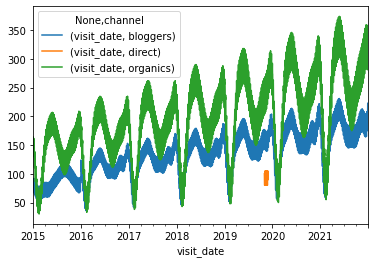

In [ ]:
df_visit.plot()

Видим некоторую цикличность в данных. В целом, динамика просмотров положительная. Во второй половине 2019 года протестировали канал direct, но от привлечения по нему отказались в конце года.

### Теперь изучим данные по конверсии. Если значение в столбце с окном конверсии пустое, то конверсии в этот день не было (аналогично дата)

In [ ]:
df_conv = df[['conversion_date','channel','window']].dropna()

Преобразовали исходник, удалив пустые строки

In [ ]:
df_conv

,conversion_date,channel,window
6,2015-01-02,bloggers,1.0
15,2015-01-14,bloggers,13.0
19,2015-01-01,bloggers,0.0
23,2015-01-05,bloggers,4.0
36,2015-01-01,bloggers,0.0
...,...,...,...
869698,2019-12-28,direct,28.0
869704,2020-01-01,direct,32.0
869707,2019-12-01,direct,1.0
869711,2019-12-05,direct,5.0


### Изучим длительность окна конверсии:

In [ ]:
df_conv.describe()

,window
count,103514.000000
mean,7.449630
std,44.974811
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,4001.000000


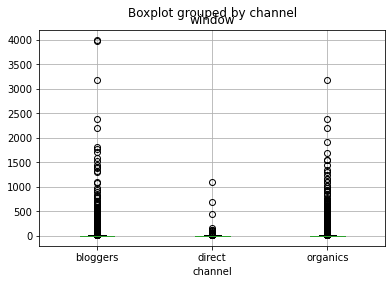

In [ ]:
df_conv.boxplot('window',by='channel')

Видим аномальный выброс

### Посмотрим распределение

In [ ]:
perc_100 = np.percentile(df_conv['window'], 100)
perc_95 = np.percentile(df_conv['window'], 95)
perc_85 = np.percentile(df_conv['window'], 85)
perc_84 = np.percentile(df_conv['window'], 84)
print(f'100-ый перцентиль {perc_100} дней,', f'95-ый перцентиль {perc_95} дней,', f'85-ый перцентиль {perc_85} дней,', f'84-ый перцентиль {perc_84} дней')

100-ый перцентиль 4001.0 дней, 95-ый перцентиль 27.0 дней, 85-ый перцентиль 8.0 дней, 84-ый перцентиль 7.0 дней


84% наших покупателей успевают совершить покупку с окном в 7 дней, но также есть длинный хвост

### Мы считаем успешной конверсией ту, которая была совершена с окном не более 7 дней

### Добавим столбец с информацией, где 1 - конверсия с заданным критерием

In [ ]:
df_conv.head(1)

,conversion_date,channel,window
6,2015-01-02,bloggers,1.0


In [ ]:
def success (x):
    if x>7:
        return 0
    else:
        return 1

In [ ]:
df_conv['conversion']=df_conv['window'].apply(success)

### Отсортируем датасет по дате конверсии

In [ ]:
df_conv=df_conv.sort_values(by=['conversion_date'],ascending=True)

In [ ]:
#pd.get_dummies(df_conv['channel'])

In [ ]:
df_conv

,conversion_date,channel,window,conversion
344155,2015-01-01,organics,0.0,1
19,2015-01-01,bloggers,0.0,1
344211,2015-01-01,organics,0.0,1
36,2015-01-01,bloggers,0.0,1
344231,2015-01-01,organics,0.0,1
...,...,...,...,...
62455,2025-06-30,bloggers,3183.0,0
20450,2026-08-13,bloggers,4001.0,0
266405,2027-05-04,bloggers,2393.0,0
649530,2028-05-02,organics,3182.0,0


В таблице имеются данные до 2029 года (синтетические), возьмем исторические (до 01/01/2021):

In [ ]:
df_conv=df_conv.loc[df['conversion_date'] <  '2021-01-01']

In [ ]:
df_conv

,conversion_date,channel,window,conversion
344155,2015-01-01,organics,0.0,1
19,2015-01-01,bloggers,0.0,1
344211,2015-01-01,organics,0.0,1
36,2015-01-01,bloggers,0.0,1
344231,2015-01-01,organics,0.0,1
...,...,...,...,...
770728,2020-12-31,organics,0.0,1
280712,2020-12-31,bloggers,0.0,1
770736,2020-12-31,organics,0.0,1
272901,2020-12-31,bloggers,41.0,0


In [ ]:
df_conv.groupby('channel')['conversion'].agg('sum')

channel
bloggers    44076
direct        538
organics    42374
Name: conversion, dtype: int64

In [ ]:
#df_conv.groupby('channel')['conversion'].agg('sum').plot(kind='bar') #для тех, кто любит графики:)
#но приводить такую визуализацию считаю нецелесообразным

### За все время мы видим почти равномерное распределение конверсий по нашим основным каналам

Так как от размещения рекламы на специализированных площадках с обзорами игр мы отказались, уберем записи по этому каналу из таблицы

In [ ]:
df_conv=df_conv.loc[df['channel'] !=  'direct']

In [ ]:
df_conv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102261 entries, 344155 to 770695
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   conversion_date  102261 non-null  datetime64[ns]
 1   channel          102261 non-null  object        
 2   window           102261 non-null  float64       
 3   conversion       102261 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.9+ MB


### Теперь посмотрим, сколько конверсий по каналам было за каждый день, сгруппировав датасет

In [ ]:
df_conv_m = df_conv.pivot_table(index='conversion_date',columns='channel',values=['conversion'],aggfunc={'conversion':'sum'})

In [ ]:
df_conv_m

conversion         
channel           bloggers organics
conversion_date                    
2015-01-01             2.0      7.0
2015-01-02            14.0     10.0
2015-01-03             9.0     12.0
2015-01-04            15.0     10.0
2015-01-05             9.0     12.0
...                    ...      ...
2020-12-27            36.0     43.0
2020-12-28            43.0     37.0
2020-12-29            36.0     36.0
2020-12-30            41.0     32.0
2020-12-31            35.0     45.0

[2192 rows x 2 columns]

### Получился вполне себе читаемый пивот с 2015 по 2020 год к количеством конверсий по маркетинговым каналам.
### Можно было бы оставить и так, но нам нужно срогнозировать конверсию на следующий год.
### Для этого преобразуем сводную таблицу в обычную

In [ ]:
df_conv_model = pd.DataFrame(df_conv_m.to_records())

In [ ]:
df_conv_model.head()

,conversion_date,"('conversion', 'bloggers')","('conversion', 'organics')"
0,2015-01-01,2.0,7.0
1,2015-01-02,14.0,10.0
2,2015-01-03,9.0,12.0
3,2015-01-04,15.0,10.0
4,2015-01-05,9.0,12.0


Избавимся от "сводного прошлого" нашей таблицы, переименовав колонки

In [ ]:
df_conv_model.columns = ['conversion_date', 'bloggers','organics']
df_conv_model

,conversion_date,bloggers,organics
0,2015-01-01,2.0,7.0
1,2015-01-02,14.0,10.0
2,2015-01-03,9.0,12.0
3,2015-01-04,15.0,10.0
4,2015-01-05,9.0,12.0
...,...,...,...
2187,2020-12-27,36.0,43.0
2188,2020-12-28,43.0,37.0
2189,2020-12-29,36.0,36.0
2190,2020-12-30,41.0,32.0


### Теперь разделим на 2 отдельных таблицы дата-конверсия: блогеры и органический трафик

In [ ]:
df_conv_blog = df_conv_model[['conversion_date', 'bloggers']]
df_conv_org = df_conv_model[['conversion_date', 'organics']]

In [ ]:
df_conv_blog.head()

,conversion_date,bloggers
0,2015-01-01,2.0
1,2015-01-02,14.0
2,2015-01-03,9.0
3,2015-01-04,15.0
4,2015-01-05,9.0


In [ ]:
df_conv_org.head()

,conversion_date,organics
0,2015-01-01,7.0
1,2015-01-02,10.0
2,2015-01-03,12.0
3,2015-01-04,10.0
4,2015-01-05,12.0


### Эти таблицы могут пригодиться по-раздельности, но для подготовки модели объединим их

In [ ]:
df_conversion = df_conv.groupby(['conversion_date','channel'],as_index=False)['conversion'].sum()

In [ ]:
df_conversion

,conversion_date,channel,conversion
0,2015-01-01,bloggers,2
1,2015-01-01,organics,7
2,2015-01-02,bloggers,14
3,2015-01-02,organics,10
4,2015-01-03,bloggers,9
...,...,...,...
4378,2020-12-29,organics,36
4379,2020-12-30,bloggers,41
4380,2020-12-30,organics,32
4381,2020-12-31,bloggers,35


### Таблица с информацией о конверсии по каналам за период с 2015 по 2020 год для построения модели подготовлена

## 6. Построение модели прогнозирования конверсии

### Графический анализ данных

In [ ]:
df_conversion.head()

,conversion_date,channel,conversion
0,2015-01-01,bloggers,2
1,2015-01-01,organics,7
2,2015-01-02,bloggers,14
3,2015-01-02,organics,10
4,2015-01-03,bloggers,9


In [ ]:
df_conversion.shape

(4383, 3)

Сформируем гистограмму по частотности конверсии:

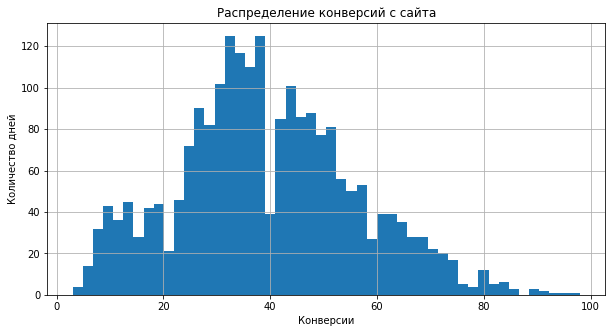

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Распределение конверсий с сайта')
plt.xlabel('Конверсии')
plt.ylabel('Количество дней')
plt.grid()
plt.hist(df_conversion.groupby('conversion_date')['conversion'].sum(),bins=50)
plt.show()

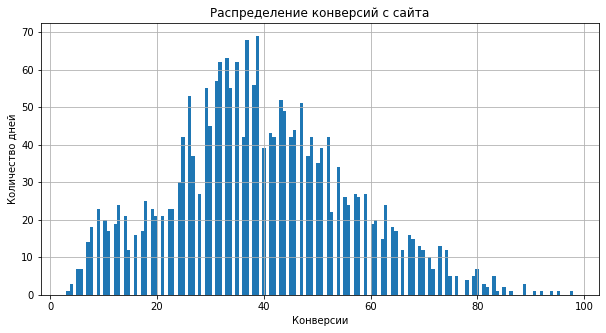

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Распределение конверсий с сайта')
plt.xlabel('Конверсии')
plt.ylabel('Количество дней')
plt.grid()
plt.hist(df_conversion.groupby('conversion_date')['conversion'].sum(),bins=150) # с увеличенным бином для точности
plt.show()

Видим явные пики и смесь в данных. Попробуем построить гистограмму по каналам конверсии.

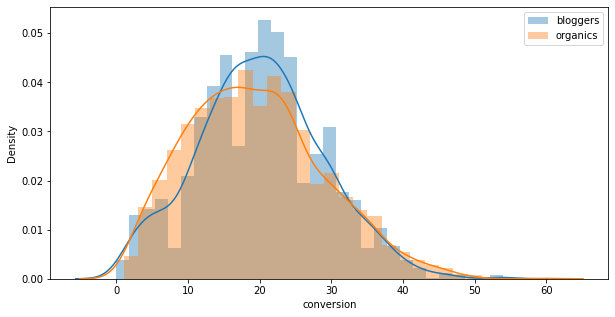

In [ ]:
plt.figure(figsize=(10,5))
channel=pd.unique(df_conversion['channel'])
for c in channel:
    sns.distplot(df_conversion.loc[df_conversion['channel']==c]['conversion'],label=c);

plt.legend();

Данные по разным каналам ведут себя схожим образом. Распределение по органическому трафику выглядит более равномерным, что вполне логично. В конверсии по блогерам видим явные пики.

### Временной ряд

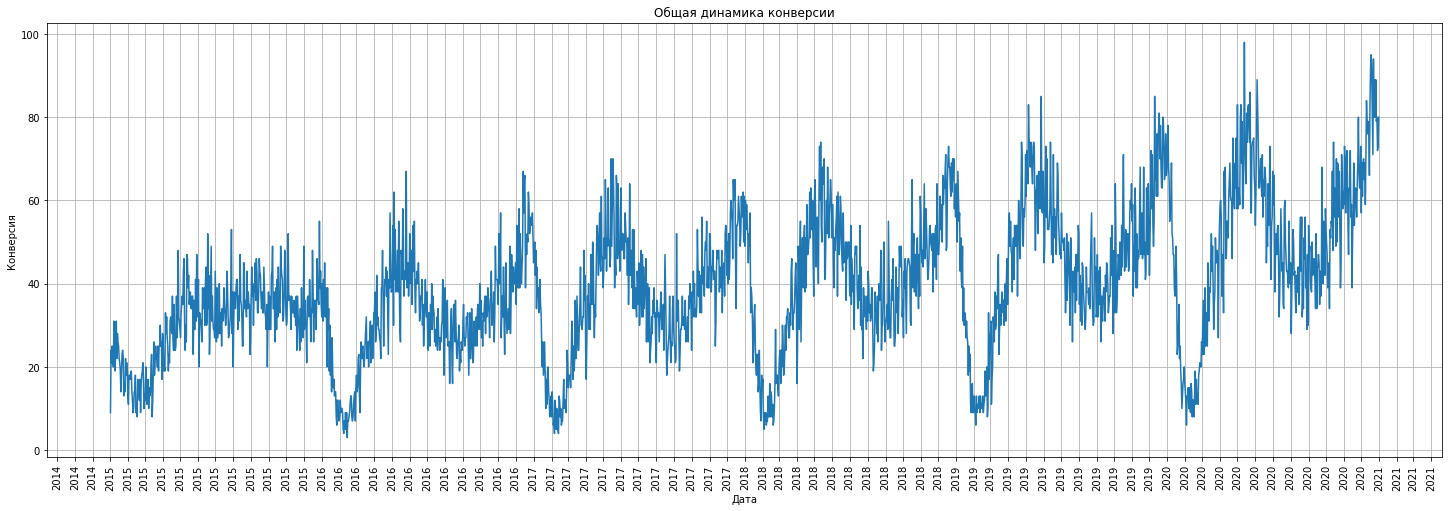

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(25,8))
plt.title("Общая динамика конверсии")
plt.xlabel("Дата")
plt.ylabel("Конверсия")
plt.xticks(rotation=90,fontsize=10)
plt.grid()
locator = mdates.MonthLocator()
X = plt.gca().xaxis
X.set_major_locator(locator)
sns.lineplot(x = df_conversion.groupby('conversion_date')['conversion'].sum().index,
            y = df_conversion.groupby('conversion_date')['conversion'].sum())
plt.show()

Отрисуем динамику конверсий по маркетинговым каналам

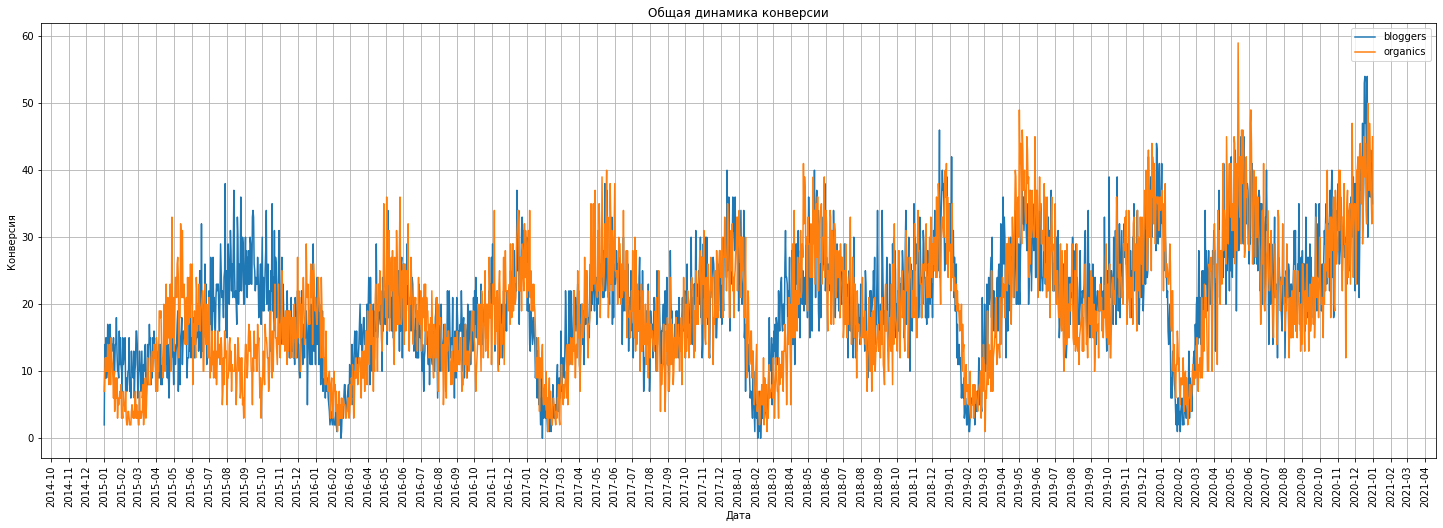

In [ ]:
plt.figure(figsize=(25,8))
plt.title("Общая динамика конверсии")
plt.xlabel("Дата")
plt.ylabel("Конверсия")
plt.xticks(rotation=90,fontsize=10) #перевернем текст оси и зададим размер для удобства отображения
plt.grid()
for c in pd.unique(df_conversion['channel']):
    sns.lineplot(
                 x = df_conversion.loc[df_conversion['channel'] == c]['conversion_date'],
                 y = df_conversion.loc[df_conversion['channel'] == c]['conversion'],
                 label = c);

locator = mdates.MonthLocator()
X = plt.gca().xaxis
X.set_major_locator(locator)

На основании графического анализа можно сделать следующие выводы:
* в данных можно увидеть сезонные явления(на это указывает циклический характер временных рядов)
* после 2016 года данные имеют схожий тренд

Для улучшения качества прогнозной модели нужно учесть:
разделение по маркетинговым каналам

* разделение по маркетинговым каналам
* выделение линейного тренда
* сезонность

### Построение прогнозной модели

Разделим данные на обучающую и контрольную выборку

In [ ]:
train = df_conversion.loc[df_conversion['conversion_date'] < '01-01-2020']
test = df_conversion.loc[df_conversion['conversion_date'] >= '01-01-2020']
train.shape, test.shape

((3651, 3), (732, 3))

#### Построим модель для общей конверсии (без разбивки по маркетинговым каналам)

In [ ]:
train0 = train.groupby('conversion_date')['conversion'].sum().reset_index()
test0 = test.groupby('conversion_date')['conversion'].sum().reset_index()

In [ ]:
test0.head()

,conversion_date,conversion
0,2020-01-01,71
1,2020-01-02,78
2,2020-01-03,68
3,2020-01-04,65
4,2020-01-05,55


Создадим model, присвоив ей объект Prophet()

In [ ]:
model = Prophet()
model

In [ ]:
train0.head()

,conversion_date,conversion
0,2015-01-01,9
1,2015-01-02,24
2,2015-01-03,21
3,2015-01-04,25
4,2015-01-05,21


Для построения модели необходимо переименовать столбцы:
ds — временная гранула, в нашем случае день
y — значения, которые будем предсказывать, в нашем случае конверсия

In [ ]:
train0.columns = ['ds','y']
test0.columns = ['ds','y']

Подгоним модель под наши данные

In [ ]:
model.fit(train0)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Алгоритм проигнорировал дневную сезонность (дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по дням).
Но обнаружена недельная и годовая сезонность, которые использованы для настройки модели.

In [ ]:
future = model.make_future_dataframe(periods=366)
future.tail(366)

,ds
1826,2020-01-01
1827,2020-01-02
1828,2020-01-03
1829,2020-01-04
1830,2020-01-05
...,...
2187,2020-12-27
2188,2020-12-28
2189,2020-12-29
2190,2020-12-30


Создадим датафрейм на 366 дней

Строим прогноз методом .predict

In [ ]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,28.727865,34.713312,54.221931,28.727865,28.727865,15.524264,15.524264,15.524264,2.649629,2.649629,2.649629,12.874635,12.874635,12.874635,0.0,0.0,0.0,44.252129
1,2015-01-02,28.737033,33.772847,51.942633,28.737033,28.737033,13.887458,13.887458,13.887458,2.087527,2.087527,2.087527,11.799931,11.799931,11.799931,0.0,0.0,0.0,42.624490
2,2015-01-03,28.746201,29.197638,47.268819,28.746201,28.746201,9.763647,9.763647,9.763647,-0.884492,-0.884492,-0.884492,10.648140,10.648140,10.648140,0.0,0.0,0.0,38.509848
3,2015-01-04,28.755368,23.907352,43.154438,28.755368,28.755368,4.871849,4.871849,4.871849,-4.553767,-4.553767,-4.553767,9.425616,9.425616,9.425616,0.0,0.0,0.0,33.627217
4,2015-01-05,28.764536,24.878969,43.498305,28.764536,28.764536,5.996631,5.996631,5.996631,-2.142573,-2.142573,-2.142573,8.139205,8.139205,8.139205,0.0,0.0,0.0,34.761168


Основные поля в прогнозе следующие:
ds — дата прогноза
yhat — спрогнозированное значение
yhat_lower — нижняя граница доверительного интервала для прогноза
yhat_upper — верхняя граница доверительного интервала для прогноза

In [ ]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
2187,2020-12-27,65.202811,55.605930,73.878980
2188,2020-12-28,66.961830,57.364355,76.424253
2189,2020-12-29,68.956374,60.211048,78.251807
2190,2020-12-30,69.751578,60.308737,78.995168
2191,2020-12-31,69.224642,60.116787,79.158428


Отрисуем прогнозные значения

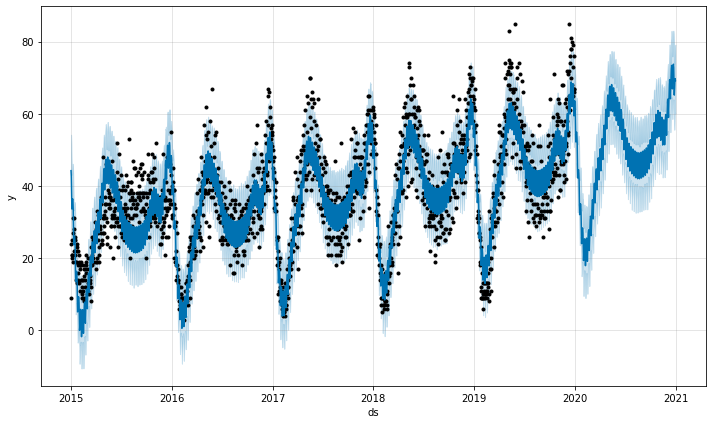

In [ ]:
model.plot(forecast);

Разложим прогоноз на основные компоненты - тренд и сезонность

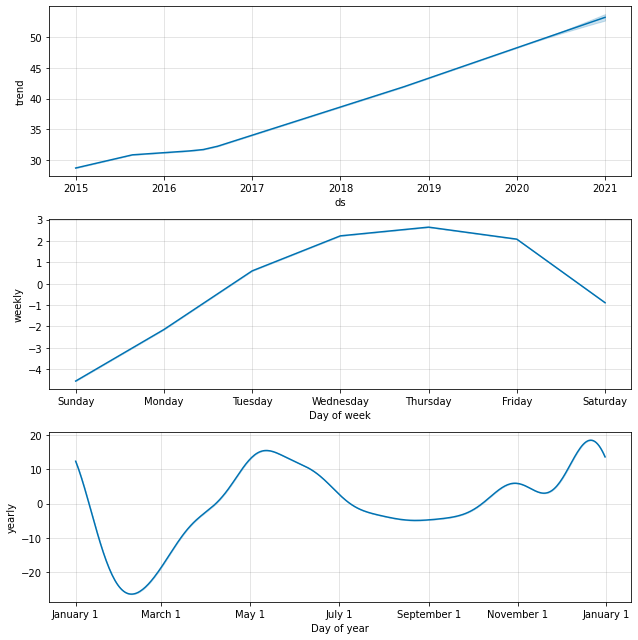

In [ ]:
model.plot_components(forecast);

#### Основные выводы по трендам и сезонности:
* Восходящий годовой тренд конверсии
* Больше всего конверсий происходит в середине недели со спадом активности в выходные
* Пик конверсий происходит в конце года иконце мая-начале июня, летом видим спад, который заканчивается к концу осени

Считаем ошибку прогноза

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(forecast['yhat'].tail(366), test0['y'])

7.629708021373644

Посмотрим в % с помощью:
np.mean() — функции библиотеки NumPy считает среднее арифметическое
np.abs() — функции библиотеки NumPy, которая вернет модули

In [ ]:
module_diff = np.abs(forecast.tail(366).reset_index()['yhat'] - test0['y'])
dif = np.mean(module_diff/test0['y'])
dif_percent = dif*100
dif_percent

21.490334300539956

Модель дала очень грубое предсказание. Сделаем такой же прогноз, но отдельно по маркетинговым каналам

In [ ]:
train1 = train.loc[train['channel']=='bloggers',['conversion_date','conversion']].rename({'conversion_date':'ds','conversion':'y'},axis=1)
train2 = train.loc[train['channel']=='organics',['conversion_date','conversion']].rename({'conversion_date':'ds','conversion':'y'},axis=1)

Готовим обучающие датасеты с разбивкой по каналам

In [ ]:
test1 = test.loc[test['channel']=='bloggers',['conversion_date','conversion']].rename({'conversion_date':'ds','conversion':'y'},axis=1)
test2 = test.loc[test['channel']=='organics',['conversion_date','conversion']].rename({'conversion_date':'ds','conversion':'y'},axis=1)

Готовим тестовые датасеты с разбивкой по каналам

In [ ]:
m1 = Prophet() #первая модель
m1.fit(train1)
m2 = Prophet() #вторая модель
m2.fit(train2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Строим прогноз для двух моделей

In [ ]:
forecast1 = m1.predict(future) # датасет с прогнозом для блогеров
forecast2 = m2.predict(future) # датасет с прогнозом для органического трафика

Визуализируем получившиеся результаты

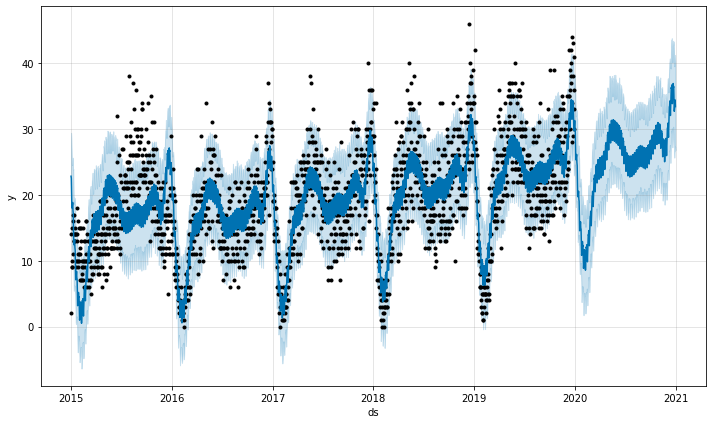

In [ ]:
m1.plot(forecast1);

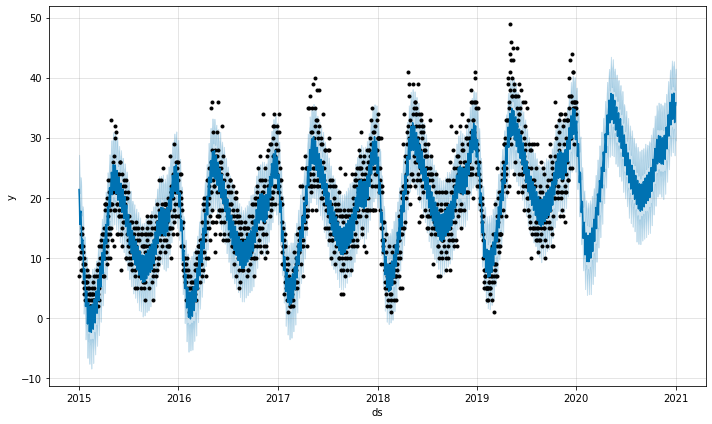

In [ ]:
m2.plot(forecast2);

Модель дает грубое предсказание, попробуем применить более тонкие настройки

#### В отдельности оценим ошибки каждой модели

In [ ]:
error_forecast1 = mean_absolute_error(forecast1['yhat'].tail(366), test1['y'])
error_forecast2 = mean_absolute_error(forecast2['yhat'].tail(366), test2['y'])
error_forecast1, error_forecast2

(5.045470105939939, 4.568184073889898)

In [ ]:
module_dif1 = np.abs(forecast1.tail(366).reset_index()['yhat'] - test1.reset_index()['y'])
dif_percent1 = np.mean(module_dif1/test1.reset_index()['y'])*100

module_dif2 = np.abs(forecast2.tail(366).reset_index()['yhat'] - test2.reset_index()['y'])
dif_percent2 = np.mean(module_dif2/test2.reset_index()['y'])*100

dif_percent1, dif_percent2

(37.806979269533855, 24.647305418051666)

Попробуем улучшить прогноз

#### Настройка параметров модели

#### Основные параметры:
- growth — тренд
 - linear — линейный, то есть данные растут или убывают равномерно
 - logistic — логистический сложносочиненный микс динамики данных
- holidays — дата-фрейм с описанием праздников/выходных дней, чтобы они учитывались при построении прогноза
- seasonality — сезонность
 - weekly_seasonality — недельная сезонность
 - daily_seasonality — дневная сезонность
 - yearly_seasonality — годовая сезонность
- seasonality_mode
 - multiplicative — мультипликативная
 - additive — аддитивная
Аддитивную сезонность имеет смысл использовать, если амплитуда колебаний сезонности из года в год не меняется. Если амплитуда колебаний сезонности из года в год меняется (т. е. размах уменьшается или увеличивается), то используем мультипликативную сезонность.
Вытащим тренд и обозначим, что у нас мультипликативная сезонность

In [ ]:
m1 = Prophet(growth = 'linear', weekly_seasonality = True, yearly_seasonality = True, seasonality_mode='multiplicative')
m1.fit(train1)

m2 = Prophet(growth = 'linear', weekly_seasonality = True, yearly_seasonality = True, seasonality_mode='multiplicative')
m2.fit(train2)
#multiplicative


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast1 = m1.predict(future)
forecast2 = m2.predict(future)

In [ ]:
error_forecast1 = mean_absolute_error(forecast1['yhat'].tail(366), test1['y'])
error_forecast2 = mean_absolute_error(forecast2['yhat'].tail(366), test2['y'])
error_forecast1, error_forecast2

(4.300201695506993, 4.0680030706960695)

In [ ]:
module_dif1 = np.abs(forecast1.tail(366).reset_index()['yhat'] - test1.reset_index()['y'])
dif_percent1 = np.mean(module_dif1/test1.reset_index()['y'])*100

module_dif2 = np.abs(forecast2.tail(366).reset_index()['yhat'] - test2.reset_index()['y'])
dif_percent2 = np.mean(module_dif2/test2.reset_index()['y'])*100

dif_percent1, dif_percent2

(24.869241570483954, 18.448150868910577)

In [ ]:
f1 = forecast1.tail(366).reset_index()['yhat']
f2 = forecast2.tail(366).reset_index()['yhat']

total_forecast = f1 + f2

mean_absolute_error(total_forecast, test0['y'])

5.890481683388565

#### Наша модель стала точнее. Напомню, что изначально ошибка составляла 7.627879225763579

#### Перестроим модель по всему набору данных и сделаем прогноз на 2021 год

In [ ]:
df_conversion_1 = df_conversion.loc[df_conversion['channel']=='bloggers',['conversion_date','conversion']].rename({'conversion_date':'ds','conversion':'y'},axis=1)
df_conversion_2 = df_conversion.loc[df_conversion['channel']=='organics',['conversion_date','conversion']].rename({'conversion_date':'ds','conversion':'y'},axis=1)

In [ ]:
m1 = Prophet(growth = 'linear', weekly_seasonality = True, yearly_seasonality = True, seasonality_mode='multiplicative')
m1.fit(df_conversion_1)

m2 = Prophet(growth = 'linear', weekly_seasonality = True, yearly_seasonality = True, seasonality_mode='multiplicative')
m2.fit(df_conversion_2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Создаем дата-фрейм на 365 дней

In [ ]:
future = m1.make_future_dataframe(periods=365)

Формируем прогноз на 2021

In [ ]:
forecast1 = m1.predict(future)
forecast2 = m2.predict(future)

Складываем конверсии на каждый день по двум маркетинговым каналам

In [ ]:
f1 = forecast1.tail(365)[['ds','yhat']].set_index('ds')
f2 = forecast2.tail(365)[['ds','yhat']].set_index('ds')

total_forecast = (f1 + f2)

In [ ]:
total_forecast.head()

,yhat
ds,
2021-01-01,76.166046
2021-01-02,70.438411
2021-01-03,63.524398
2021-01-04,65.257911
2021-01-05,66.764533


Визуализируем наш прогноз на 2021 год

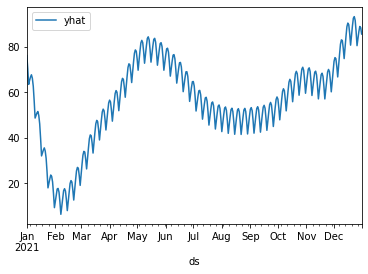

In [ ]:
total_forecast.plot()

Построим прогноз конверсии по маркетинговым каналам

In [ ]:
f1['channel']='bloggers'
f2['channel']='organics'
total_forecast_by_channel = pd.concat([f1,f2],ignore_index=False)
total_forecast_by_channel= total_forecast_by_channel.sort_values(by=['ds','channel'],ascending=True)

In [ ]:
total_forecast_by_channel.head()

,yhat,channel
ds,,
2021-01-01,37.520566,bloggers
2021-01-01,38.645480,organics
2021-01-02,34.638599,bloggers
2021-01-02,35.799811,organics
2021-01-03,31.174258,bloggers


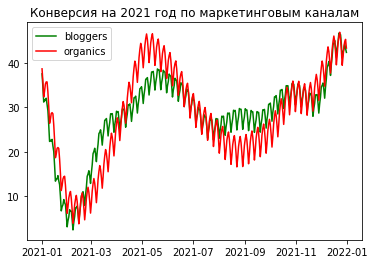

In [ ]:
 line_1 = f1['yhat']
 line_2 = f2['yhat']

 fig, ax = plt.subplots()

 plt.title('Конверсия на 2021 год по маркетинговым каналам')
 ax.plot(line_1, color = 'green', label = 'bloggers')
 ax.plot(line_2, color = 'red', label = 'organics')
 ax.legend(loc = 'upper left')
 plt.show()

Выгрузим прогноз для маркетингового отдела (общий и разбивку)

In [ ]:
total_forecast.to_csv('forecast_2021.csv')
total_forecast_by_channel.to_csv('forecast_2021_by_channel.csv')